In [1]:
import tensorflow as tf
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

In [2]:
def prec_recall(df):
    '''Assumes columns of pred and label'''
    tp=df[(df['label']==1)&(df['pred']==1)].shape[0]#number of true positives
    recall = tp/df['label'].sum()                   #recall
    prec =   tp/df['pred'].sum()                    #precision
    fp=df[(df['label']!=1)&(df['pred']==1)].shape[0]#number of false positives
    fpr=fp/df['pred'].sum()                         #False positive rate
    return prec,recall,fpr

In [3]:
fn="creditcard.csv"
df=pd.read_csv(fn)

In [4]:
cols=[col for col in df.columns if col not in ["Class"]]

In [5]:
dftrain,dftest=train_test_split(df,test_size=0.15)

In [6]:
numinps= len(cols)
numinps

30

<p>Test/Train split for train and eval data.</p>

In [7]:
dftrain2,dfeval=train_test_split(dftrain,test_size=0.15)

<p>Building the autoencoder</p>

<p>So the Threshold is determined below and then put into the model as hardwired (not used to determine the threshold - no loops here) so that we can export the model at the same time.</p>

In [8]:
encodedim=14
hiddim=encodedim//2
learnrate=0.001
droprate=0.2
threshold=tf.constant(55.)
inputs=tf.placeholder(tf.float32, shape=(None,numinps),name="inputs")
#mode=tf.placeholder(tf.string, name="mode")

dense0 = tf.layers.dense(inputs=inputs, units=encodedim, activation=tf.nn.tanh)
dropout0 = tf.layers.dropout(inputs=dense0, rate=droprate)

dense1 = tf.layers.dense(inputs=dropout0, units=hiddim, activation=tf.nn.relu)
dropout1 = tf.layers.dropout(inputs=dense1, rate=droprate)

dense2 = tf.layers.dense(inputs=dropout1, units=hiddim, activation=tf.nn.tanh)
dropout2 = tf.layers.dropout(inputs=dense2, rate=droprate)

dense3 = tf.layers.dense(inputs=dropout2, units=numinps, activation=tf.nn.relu)
dropout3 = tf.layers.dropout(inputs=dense3, rate=droprate)

loss=tf.losses.mean_squared_error(labels=inputs,predictions=dropout3)
Yout=tf.cast(tf.math.greater(loss,threshold), tf.int32)
trainstep=tf.train.AdamOptimizer(learning_rate=learnrate).minimize(loss)


<p>Training Autoencoder and then exporting saved_model format.</p>

In [9]:
init = tf.global_variables_initializer()
batchsize=100
#xbatch=dftrain2.loc[:,cols].head(10).values
evalbatch=dfeval[cols]
numepochs=4

treerr=[]
everr=[]

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(numepochs):
        for i in range(dftrain2.shape[0]//batchsize):
            xbatch=dftrain2.iloc[i*batchsize:(i+1)*batchsize][cols]
            _,ltr=sess.run([trainstep,loss],feed_dict={inputs:xbatch})
            print("train: ",epoch,i,ltr)
            if i%20==0:
                l=sess.run([loss],feed_dict={inputs:evalbatch})
                print("evalu: ",epoch,i,l)
                treerr.append(ltr)
                everr.append(l)
     
    print("Running Test data...")
    out=[]
    for i in range(dftest.shape[0]):
        testbatch=np.array([dftest.iloc[i][cols].values])
        l=sess.run([loss,Yout],feed_dict={inputs:testbatch})
        out.append([dftest.iloc[i]['Class'],l[0]])
    tf.saved_model.simple_save(sess,"./m", inputs=
                           {
                               "inputs":inputs#,'labels':labels,"learnrate":learnrate,"droprate":droprate,"mode":mode
                           },
                           outputs={"Yout":Yout}#,"batchloss":batchloss}
                          )

train:  0 0 0.8786459
evalu:  0 0 [1.1967247]
train:  0 1 0.82111293
train:  0 2 0.8849528
train:  0 3 1.006468
train:  0 4 1.1138202
train:  0 5 1.1362659
train:  0 6 0.96332306
train:  0 7 1.052875
train:  0 8 1.0396622
train:  0 9 1.6054584
train:  0 10 0.8529419
train:  0 11 0.90086263
train:  0 12 2.1639411
train:  0 13 0.85052085
train:  0 14 0.8396027
train:  0 15 1.2677279
train:  0 16 1.1301173
train:  0 17 0.8110599
train:  0 18 1.4951175
train:  0 19 0.9278629
train:  0 20 2.3693
evalu:  0 20 [1.1779827]
train:  0 21 1.146614
train:  0 22 0.987472
train:  0 23 0.86754674
train:  0 24 0.8092464
train:  0 25 1.0109401
train:  0 26 0.96182066
train:  0 27 3.352582
train:  0 28 0.7351525
train:  0 29 0.7405391
train:  0 30 0.8156986
train:  0 31 1.7724568
train:  0 32 0.8682583
train:  0 33 1.4406427
train:  0 34 0.8096988
train:  0 35 0.9187361
train:  0 36 1.0868374
train:  0 37 1.5156949
train:  0 38 0.96341634
train:  0 39 1.1342824
train:  0 40 1.170228
evalu:  0 40 [1.1645

evalu:  0 340 [1.0503117]
train:  0 341 0.8726758
train:  0 342 0.9474022
train:  0 343 0.7768831
train:  0 344 0.7294697
train:  0 345 0.7578459
train:  0 346 0.7411533
train:  0 347 0.60353196
train:  0 348 0.8069346
train:  0 349 0.92399675
train:  0 350 1.8965787
train:  0 351 0.9033384
train:  0 352 0.66389716
train:  0 353 0.86067903
train:  0 354 0.8178473
train:  0 355 1.1127583
train:  0 356 0.67781526
train:  0 357 0.748368
train:  0 358 1.007356
train:  0 359 0.72736686
train:  0 360 0.734645
evalu:  0 360 [1.0466993]
train:  0 361 1.0393627
train:  0 362 1.1794387
train:  0 363 0.82918304
train:  0 364 0.8529618
train:  0 365 0.73344237
train:  0 366 0.81827456
train:  0 367 2.113022
train:  0 368 1.0593925
train:  0 369 1.2853152
train:  0 370 0.88700765
train:  0 371 0.9962818
train:  0 372 0.6535548
train:  0 373 2.2629473
train:  0 374 0.9303637
train:  0 375 0.90361166
train:  0 376 0.6802382
train:  0 377 1.255153
train:  0 378 0.7796134
train:  0 379 1.1434472
train:

evalu:  0 700 [1.001342]
train:  0 701 0.6035923
train:  0 702 0.6480806
train:  0 703 0.6183539
train:  0 704 0.6052943
train:  0 705 0.64395314
train:  0 706 0.89964354
train:  0 707 0.65537035
train:  0 708 0.71801156
train:  0 709 0.67213064
train:  0 710 0.704797
train:  0 711 0.9032457
train:  0 712 0.89001995
train:  0 713 1.1490571
train:  0 714 0.59612846
train:  0 715 1.299995
train:  0 716 0.8797443
train:  0 717 0.60999304
train:  0 718 0.68360007
train:  0 719 0.86236346
train:  0 720 0.9827771
evalu:  0 720 [0.9997313]
train:  0 721 0.7488405
train:  0 722 1.0683244
train:  0 723 0.9847111
train:  0 724 1.1353264
train:  0 725 0.63723683
train:  0 726 0.9868592
train:  0 727 0.83359945
train:  0 728 0.72151816
train:  0 729 0.7236063
train:  0 730 1.305177
train:  0 731 0.7959205
train:  0 732 0.6329341
train:  0 733 0.8686897
train:  0 734 0.9440889
train:  0 735 0.8509927
train:  0 736 0.8231232
train:  0 737 2.1975093
train:  0 738 0.83826286
train:  0 739 0.7683052
tr

train:  0 1053 0.65626734
train:  0 1054 0.67120266
train:  0 1055 1.0360036
train:  0 1056 0.65548825
train:  0 1057 0.5744907
train:  0 1058 1.3992527
train:  0 1059 0.573332
train:  0 1060 0.67490315
evalu:  0 1060 [0.9725604]
train:  0 1061 0.7137406
train:  0 1062 0.67749065
train:  0 1063 0.57646304
train:  0 1064 1.175021
train:  0 1065 0.7015683
train:  0 1066 0.6087624
train:  0 1067 0.5440642
train:  0 1068 0.6689633
train:  0 1069 0.64796764
train:  0 1070 0.73963606
train:  0 1071 0.7409759
train:  0 1072 0.6864808
train:  0 1073 0.88839406
train:  0 1074 0.75387746
train:  0 1075 0.68851626
train:  0 1076 0.94491464
train:  0 1077 0.73860544
train:  0 1078 1.047606
train:  0 1079 0.9182543
train:  0 1080 0.732986
evalu:  0 1080 [0.97063243]
train:  0 1081 1.3548778
train:  0 1082 0.795696
train:  0 1083 2.1093514
train:  0 1084 0.7736961
train:  0 1085 1.3839289
train:  0 1086 0.84636515
train:  0 1087 2.33511
train:  0 1088 0.8208681
train:  0 1089 0.6491308
train:  0 109

train:  1 167 0.82576334
train:  1 168 2.7068844
train:  1 169 0.7484001
train:  1 170 0.5817629
train:  1 171 0.85403997
train:  1 172 0.65007126
train:  1 173 0.8195813
train:  1 174 0.69817823
train:  1 175 0.55795807
train:  1 176 0.7225907
train:  1 177 0.6541641
train:  1 178 0.862341
train:  1 179 0.91222256
train:  1 180 0.5460241
evalu:  1 180 [0.9471139]
train:  1 181 0.85028285
train:  1 182 0.64447916
train:  1 183 0.5947928
train:  1 184 1.0165747
train:  1 185 0.60308295
train:  1 186 1.1011122
train:  1 187 1.6643904
train:  1 188 0.66799474
train:  1 189 1.2090278
train:  1 190 0.6745075
train:  1 191 0.6288793
train:  1 192 0.83458465
train:  1 193 0.5456392
train:  1 194 0.5072552
train:  1 195 0.6699589
train:  1 196 0.5950868
train:  1 197 0.6856896
train:  1 198 0.64283615
train:  1 199 0.6162569
train:  1 200 0.66808176
evalu:  1 200 [0.9458729]
train:  1 201 0.6451603
train:  1 202 1.3886269
train:  1 203 0.74966717
train:  1 204 0.4873076
train:  1 205 0.6793046

train:  1 518 1.0349618
train:  1 519 0.5093748
train:  1 520 0.6353729
evalu:  1 520 [0.9305286]
train:  1 521 0.5792287
train:  1 522 1.1336546
train:  1 523 1.3963017
train:  1 524 1.843099
train:  1 525 0.88945645
train:  1 526 0.66695017
train:  1 527 0.8283105
train:  1 528 0.6089874
train:  1 529 0.77555585
train:  1 530 0.7097552
train:  1 531 0.7096283
train:  1 532 0.67994916
train:  1 533 0.7210693
train:  1 534 0.7110424
train:  1 535 1.1468643
train:  1 536 1.9526461
train:  1 537 0.68273973
train:  1 538 0.48234805
train:  1 539 0.6033944
train:  1 540 0.71323764
evalu:  1 540 [0.92972535]
train:  1 541 0.55496687
train:  1 542 0.66299534
train:  1 543 0.6188621
train:  1 544 0.64560527
train:  1 545 0.44356316
train:  1 546 0.56589544
train:  1 547 0.5864779
train:  1 548 0.8134347
train:  1 549 0.481138
train:  1 550 0.6340793
train:  1 551 0.74675375
train:  1 552 0.7995599
train:  1 553 0.51602566
train:  1 554 0.7060662
train:  1 555 0.69919354
train:  1 556 0.571104

train:  1 862 0.7446627
train:  1 863 0.46817797
train:  1 864 0.630106
train:  1 865 0.719373
train:  1 866 0.9727906
train:  1 867 0.48194093
train:  1 868 0.5792991
train:  1 869 0.7981276
train:  1 870 1.1787244
train:  1 871 0.7584665
train:  1 872 0.79219496
train:  1 873 0.7048607
train:  1 874 0.57732725
train:  1 875 0.81773764
train:  1 876 0.79314965
train:  1 877 1.0717677
train:  1 878 1.3822584
train:  1 879 0.53240293
train:  1 880 0.7200777
evalu:  1 880 [0.91895676]
train:  1 881 0.78575706
train:  1 882 0.8221199
train:  1 883 0.6199007
train:  1 884 1.1691167
train:  1 885 0.713298
train:  1 886 0.58889437
train:  1 887 1.1430472
train:  1 888 0.98628074
train:  1 889 0.522299
train:  1 890 0.817152
train:  1 891 0.62149465
train:  1 892 0.70881444
train:  1 893 0.7197404
train:  1 894 0.57577384
train:  1 895 1.7984803
train:  1 896 0.8757447
train:  1 897 0.5110891
train:  1 898 0.8282769
train:  1 899 0.662297
train:  1 900 0.6895817
evalu:  1 900 [0.9186006]
trai

train:  1 1207 0.603915
train:  1 1208 0.8013272
train:  1 1209 1.096337
train:  1 1210 0.92393166
train:  1 1211 0.8197469
train:  1 1212 0.43883452
train:  1 1213 0.59485465
train:  1 1214 0.68729424
train:  1 1215 0.6748532
train:  1 1216 1.2033545
train:  1 1217 0.8544743
train:  1 1218 0.5527628
train:  1 1219 0.5376373
train:  1 1220 0.6476908
evalu:  1 1220 [0.9108398]
train:  1 1221 1.0380305
train:  1 1222 0.5685123
train:  1 1223 0.6688236
train:  1 1224 0.76843643
train:  1 1225 0.5956304
train:  1 1226 0.84901637
train:  1 1227 0.5433454
train:  1 1228 0.5251633
train:  1 1229 0.8068374
train:  1 1230 0.6684217
train:  1 1231 0.5574812
train:  1 1232 1.1088084
train:  1 1233 0.8751742
train:  2 0 0.58555764
evalu:  2 0 [0.9105314]
train:  2 1 0.54927146
train:  2 2 0.61724883
train:  2 3 0.74590105
train:  2 4 0.7141805
train:  2 5 0.8096768
train:  2 6 0.6866818
train:  2 7 0.77772003
train:  2 8 0.7526395
train:  2 9 1.2448735
train:  2 10 0.59158355
train:  2 11 0.585959

train:  2 322 0.6296251
train:  2 323 0.57602125
train:  2 324 0.64368016
train:  2 325 0.8344209
train:  2 326 0.9914121
train:  2 327 0.5785963
train:  2 328 0.54902446
train:  2 329 0.77795345
train:  2 330 1.335861
train:  2 331 0.51486903
train:  2 332 0.6969838
train:  2 333 2.7792454
train:  2 334 0.6645514
train:  2 335 0.50759876
train:  2 336 0.5121073
train:  2 337 0.72113454
train:  2 338 2.3828416
train:  2 339 0.7501125
train:  2 340 0.7176814
evalu:  2 340 [0.90464264]
train:  2 341 0.71636635
train:  2 342 0.83346677
train:  2 343 0.6340996
train:  2 344 0.6034167
train:  2 345 0.63721246
train:  2 346 0.5664722
train:  2 347 0.50565684
train:  2 348 0.687792
train:  2 349 0.77669203
train:  2 350 1.7015133
train:  2 351 0.7280365
train:  2 352 0.52934015
train:  2 353 0.73047084
train:  2 354 0.6829692
train:  2 355 0.9776945
train:  2 356 0.55897844
train:  2 357 0.5894986
train:  2 358 0.8698948
train:  2 359 0.6030914
train:  2 360 0.5894459
evalu:  2 360 [0.9043657

train:  2 678 0.99519485
train:  2 679 0.84625375
train:  2 680 0.56733555
evalu:  2 680 [0.8997115]
train:  2 681 0.76863873
train:  2 682 0.5190171
train:  2 683 0.70339924
train:  2 684 0.54192996
train:  2 685 0.70776546
train:  2 686 0.5711627
train:  2 687 1.1704925
train:  2 688 1.5896218
train:  2 689 0.59106356
train:  2 690 1.4602116
train:  2 691 0.73581207
train:  2 692 0.71297103
train:  2 693 0.7509394
train:  2 694 0.6828522
train:  2 695 0.83209735
train:  2 696 0.5911527
train:  2 697 0.5978572
train:  2 698 0.59056777
train:  2 699 0.7513731
train:  2 700 0.67091346
evalu:  2 700 [0.89966416]
train:  2 701 0.4953383
train:  2 702 0.57035285
train:  2 703 0.5384105
train:  2 704 0.5406341
train:  2 705 0.5174014
train:  2 706 0.7994968
train:  2 707 0.5624466
train:  2 708 0.6224085
train:  2 709 0.58109534
train:  2 710 0.62711936
train:  2 711 0.8117952
train:  2 712 0.7775436
train:  2 713 1.002899
train:  2 714 0.5387534
train:  2 715 1.2112851
train:  2 716 0.7701

train:  2 1035 0.5747231
train:  2 1036 0.6687074
train:  2 1037 0.8074593
train:  2 1038 0.9304202
train:  2 1039 0.59700817
train:  2 1040 0.57616454
evalu:  2 1040 [0.89586085]
train:  2 1041 0.4806774
train:  2 1042 1.025377
train:  2 1043 0.7092062
train:  2 1044 0.63158315
train:  2 1045 0.5928896
train:  2 1046 0.8576702
train:  2 1047 0.5802187
train:  2 1048 2.022455
train:  2 1049 0.49444488
train:  2 1050 1.2674651
train:  2 1051 1.4307767
train:  2 1052 0.64584655
train:  2 1053 0.58762294
train:  2 1054 0.61005443
train:  2 1055 0.9379442
train:  2 1056 0.5866487
train:  2 1057 0.5101515
train:  2 1058 1.2852917
train:  2 1059 0.5100893
train:  2 1060 0.61164373
evalu:  2 1060 [0.89581555]
train:  2 1061 0.6389728
train:  2 1062 0.59430474
train:  2 1063 0.5282745
train:  2 1064 1.117045
train:  2 1065 0.6417199
train:  2 1066 0.5319027
train:  2 1067 0.48666745
train:  2 1068 0.58522016
train:  2 1069 0.586408
train:  2 1070 0.6563411
train:  2 1071 0.64978355
train:  2 1

train:  3 158 0.9058029
train:  3 159 0.5623884
train:  3 160 0.61757696
evalu:  3 160 [0.89251167]
train:  3 161 1.1080991
train:  3 162 0.76064324
train:  3 163 0.654488
train:  3 164 0.6895654
train:  3 165 0.7808381
train:  3 166 0.5018384
train:  3 167 0.7651692
train:  3 168 2.582538
train:  3 169 0.7044157
train:  3 170 0.53748095
train:  3 171 0.7765289
train:  3 172 0.6071064
train:  3 173 0.7336136
train:  3 174 0.66125685
train:  3 175 0.51711404
train:  3 176 0.67301077
train:  3 177 0.5906328
train:  3 178 0.8073518
train:  3 179 0.8431895
train:  3 180 0.5054076
evalu:  3 180 [0.89213645]
train:  3 181 0.8145495
train:  3 182 0.5804156
train:  3 183 0.55386305
train:  3 184 0.942722
train:  3 185 0.5480937
train:  3 186 1.0128753
train:  3 187 1.5925553
train:  3 188 0.624451
train:  3 189 1.135463
train:  3 190 0.636846
train:  3 191 0.5879559
train:  3 192 0.7761393
train:  3 193 0.5047111
train:  3 194 0.46796778
train:  3 195 0.62425584
train:  3 196 0.54892796
train:

train:  3 515 0.8329925
train:  3 516 0.58029026
train:  3 517 0.84857404
train:  3 518 0.98105013
train:  3 519 0.4824671
train:  3 520 0.6032677
evalu:  3 520 [0.8893118]
train:  3 521 0.5516407
train:  3 522 1.0848157
train:  3 523 1.3506078
train:  3 524 1.7607247
train:  3 525 0.8496009
train:  3 526 0.61147636
train:  3 527 0.79597753
train:  3 528 0.5876392
train:  3 529 0.71334946
train:  3 530 0.66194
train:  3 531 0.6739556
train:  3 532 0.6543192
train:  3 533 0.6773732
train:  3 534 0.66478467
train:  3 535 1.0799217
train:  3 536 1.9004033
train:  3 537 0.6344784
train:  3 538 0.4609073
train:  3 539 0.577139
train:  3 540 0.66127527
evalu:  3 540 [0.8888527]
train:  3 541 0.52601403
train:  3 542 0.64035475
train:  3 543 0.5903221
train:  3 544 0.603236
train:  3 545 0.41695946
train:  3 546 0.5388743
train:  3 547 0.5634549
train:  3 548 0.77652556
train:  3 549 0.45598975
train:  3 550 0.60667056
train:  3 551 0.7002842
train:  3 552 0.7614867
train:  3 553 0.49291545
t

train:  3 849 0.86865884
train:  3 850 0.5538558
train:  3 851 0.5909898
train:  3 852 0.9048284
train:  3 853 1.3734599
train:  3 854 0.5453544
train:  3 855 0.65350705
train:  3 856 0.5478584
train:  3 857 0.7580716
train:  3 858 1.5182058
train:  3 859 0.9302705
train:  3 860 0.5852078
evalu:  3 860 [0.8865688]
train:  3 861 0.7351407
train:  3 862 0.71377504
train:  3 863 0.44678938
train:  3 864 0.6005643
train:  3 865 0.6922539
train:  3 866 0.93375194
train:  3 867 0.46520883
train:  3 868 0.54555947
train:  3 869 0.7770092
train:  3 870 1.1488984
train:  3 871 0.7255047
train:  3 872 0.7556367
train:  3 873 0.6784524
train:  3 874 0.5545763
train:  3 875 0.7748529
train:  3 876 0.77307534
train:  3 877 1.051692
train:  3 878 1.3446921
train:  3 879 0.5096072
train:  3 880 0.6812435
evalu:  3 880 [0.8860244]
train:  3 881 0.74310154
train:  3 882 0.79707754
train:  3 883 0.6002063
train:  3 884 1.1373583
train:  3 885 0.68498015
train:  3 886 0.5727555
train:  3 887 1.096686
tra

train:  3 1183 0.5893039
train:  3 1184 0.66121715
train:  3 1185 0.8125016
train:  3 1186 0.5929029
train:  3 1187 0.5909613
train:  3 1188 0.71107095
train:  3 1189 0.63737136
train:  3 1190 1.0832665
train:  3 1191 0.58441186
train:  3 1192 0.6588402
train:  3 1193 0.7734965
train:  3 1194 0.7333313
train:  3 1195 0.6245362
train:  3 1196 0.6662344
train:  3 1197 1.0304805
train:  3 1198 0.505826
train:  3 1199 0.7008331
train:  3 1200 0.4601569
evalu:  3 1200 [0.88370097]
train:  3 1201 0.62796617
train:  3 1202 1.0919532
train:  3 1203 0.66912025
train:  3 1204 0.5216104
train:  3 1205 0.6582994
train:  3 1206 0.691079
train:  3 1207 0.5771231
train:  3 1208 0.78046274
train:  3 1209 1.0760444
train:  3 1210 0.8916748
train:  3 1211 0.79514176
train:  3 1212 0.4215648
train:  3 1213 0.5758271
train:  3 1214 0.6562874
train:  3 1215 0.64541936
train:  3 1216 1.1757239
train:  3 1217 0.81537044
train:  3 1218 0.53170425
train:  3 1219 0.5197373
train:  3 1220 0.624975
evalu:  3 1220

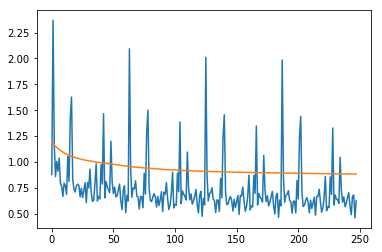

In [10]:
plt.plot(treerr)
plt.plot(everr)

In [11]:
out=np.array(out)
dfout=pd.DataFrame(data={"label":out[:,0],"err":out[:,1]})

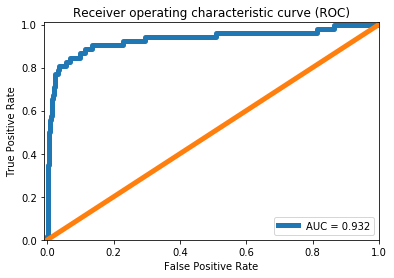

In [12]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(dfout.label, dfout.err)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

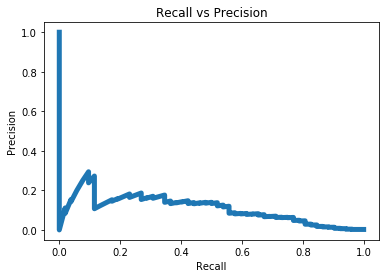

In [13]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(dfout.label, dfout.err)
plt.plot(recall_rt, precision_rt, linewidth=5, label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

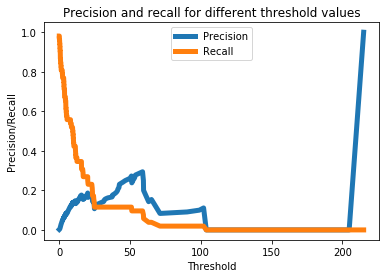

In [14]:
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [15]:
###Selecting threshold
thresh=55
print("correct inlier {:5.3f}%, num pred outlier {},  true positive {}, actual num outliers {}".format(
                             dfout[(dfout['err']<thresh)&dfout['label']!=1].shape[0]/dfout.shape[0],
                             dfout[dfout['err']>=thresh].shape[0],
                             dfout[(dfout['err']>=thresh)&dfout['label']==1].shape[0],
                             dfout['label'].sum()))
recall = dfout[(dfout['err']>=thresh)&dfout['label']==1].shape[0]/dfout['label'].sum()
prec = dfout[(dfout['err']>=thresh)&dfout['label']==1].shape[0]/dfout[dfout['err']>=thresh].shape[0]
print("prec {}, recall {}".format(prec,recall))

correct inlier 0.998%, num pred outlier 18,  true positive 5, actual num outliers 52.0
prec 0.2777777777777778, recall 0.09615384615384616


In [16]:
#Defining Prediction from loss
dfout['pred']=0
dfout.loc[dfout['err']>thresh,'pred']=1

In [17]:
prec2,recall2,fpr2=prec_recall(dfout)
print("autoencoder   prec {:5.3f}, recall {:5.3f}, false pos rate {:5.3f}".format(prec2,recall2,fpr2))

autoencoder   prec 0.278, recall 0.096, false pos rate 0.722
